<a href="https://colab.research.google.com/github/Mathieu-Putz/Playing-with-PINNs/blob/main/1%20-%20Simple%20exponential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import numpy as np  
import sympy as sy
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# 1. Maximally simple first order ODE

Let's start by trying to find an approximate solution to the following (maximally simple) initial value problem, with an ODE:

y'(t) = y(t)

y(t=0) = 1

For this system, we actually know the exact solution.
y(t) = e^t

Of course, we don't actually want to just use the exact solution; the whole point is to approximate it. But we can use it to generate "datapoints" at random points. 



In [ ]:
# let's define some random points between -5 and 5
time_points = (torch.rand((100))-.5)*10
time_points, _ = torch.sort(time_points)
datapoints = torch.exp(time_points)

Let's call the predictions of our PINN y_pred_i.

Now, we need to find a PINN that minimises the following loss:

MSE = sum_over_i (( y_pred_i - y(t_i) )^2 + (y_pred_0 - 1)^2


In [ ]:
# Define the Neural Network:
model = nn.Sequential(nn.Linear(1, 50), nn.ReLU(), nn.Linear(50,1))
learning_rate = 1e-3

In [ ]:
# add lambda parameter for weight of different losses
def loss(time_points, boundary_points, datapoints, boundary_values):
  y_pred = model(time_points)
  y_pred_boundary = model(boundary_points)
  return torch.mean((y_pred - datapoints)**2) + 1* torch.mean((y_pred_boundary - boundary_values)**2)

boundary_points = torch.tensor([0.0])
boundary_values = torch.exp(boundary_points) 
#print(loss(time_points[:,None], boundary_points[:,None], datapoints[:,None], boundary_values[:,None]))

In [ ]:
# Optimize 
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# The collocation points used by Lagaris

x = time_points[:,None]

# Run the optimizer
def closure():
    optimizer.zero_grad()
    # In retrospect, I'm not sure adding [:,None] to each variable was necessary or whether it even made sense.
    # Rather than trying to find out, I'm happy to notice that it worked well enough and move on to more interesting examples.
    l = loss(time_points[:,None], boundary_points[:,None], datapoints[:,None], boundary_values[:,None])
    l.backward()
    return l
#print(loss(time_points[:,None], boundary_points[:,None], datapoints[:,None], boundary_values[:,None]))
for i in range(10000):
    optimizer.step(closure)
    # to observe the loss with number of iterations, uncomment following two lines:
    #if i%300 ==299:
    #  print(loss(time_points[:,None], boundary_points[:,None], datapoints[:,None], boundary_values[:,None]))

Plot the result:

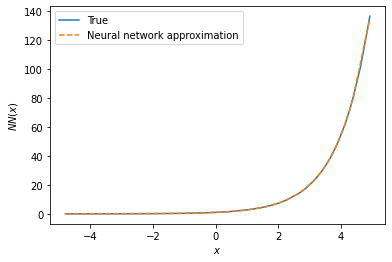

In [ ]:
# Let's compare the result to the true solution
time_points_np = time_points.numpy()
datapoints_np = datapoints.numpy()
y_pred_np     = model(time_points[:,None]).detach().numpy()



fig, ax = plt.subplots()
ax.plot(time_points_np, datapoints_np, label='True')
ax.plot(time_points_np, y_pred_np, '--', label='Neural network approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$NN(x)$')
plt.legend(loc='best');

Looks good! This solution is highly imperfect. Network architecture and learning rate are more or less chosen randomly for instance and it's quite possible there may be other mistakes too. But instead of overoptimizing, let's move on to a slightly more complicated example.